In [1]:
from sphedron import Icosphere, NestedIcospheres
from sphedron.utils.extra import get_mesh_landmask, plot_2d_mesh
from sphedron.utils.helpers import faces_to_edges
import numpy as np

In [2]:
# mesh = Icosphere.from_base(refine_factor=64)
mesh = NestedIcospheres(factors=[1,2,2,2,2,2,2])
print(mesh)
# mesh = mesm.meshes[-1]
#mesh.mask_nodes(get_mesh_landmask(mesh))

Mesh has: #nodes: 40962
          #faces: 109220
          #edges: 327660
          #edges_unique: 163830
          metadata: {'depth': [1, 2, 4, 8, 16, 32, 64], 'factor': [1, 2, 2, 2, 2, 2, 2]}


In [3]:
mesh = mesh.meshes[-1]
print(mesh)

Mesh has: #nodes: 40962
          #faces: 81920
          #edges: 245760
          #edges_unique: 122880
          metadata: {'factor': 2}


In [4]:
mesh.mask_nodes(get_mesh_landmask(mesh))

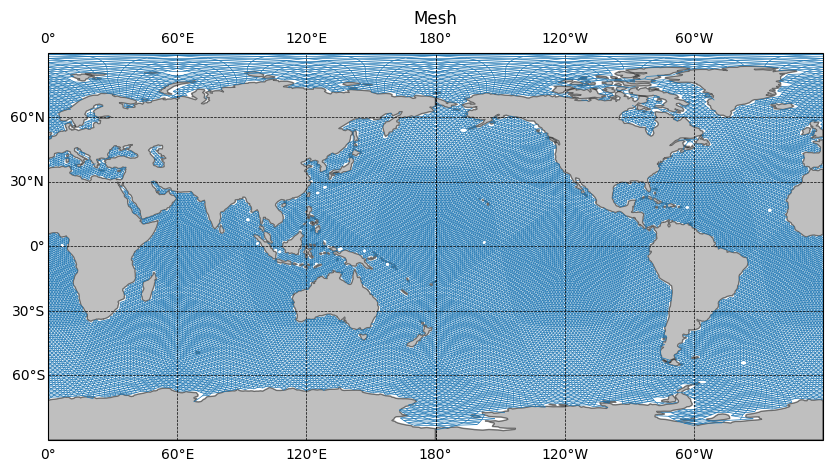

In [5]:
plot_2d_mesh(mesh)

In [85]:
# w  ij ​ =(cotα+cotβ)
# Δ 𝑓 ( 𝑖 ) = 1 𝐴 𝑖 ∑ 𝑗 𝑤 𝑖 𝑗 ( 𝑓 𝑗 − 𝑓 𝑖 ) Δf(i)=  A  i ​ 1 ​ j ∑ ​ w  ij ​ (f  j ​ −f  i )

In [6]:
print(mesh)

Mesh has: #nodes: 29176
          #faces: 55614
          #edges: 169708
          #edges_unique: 84854
          metadata: {'factor': 2}


In [ ]:
from collections import defaultdict

faces = mesh.faces
nodes = mesh.nodes


In [9]:
%%time
# map each node and edge to the faces it participates in
node2face = defaultdict(list)
edge2face = defaultdict(list)
for i,fc in enumerate(faces):
    fc = fc.tolist()
    for f in fc:
        node2face[f].append(i)
    edge2face[(fc[0],fc[1])].append(i)
    edge2face[(fc[1],fc[0])].append(i)
    edge2face[(fc[1],fc[2])].append(i)
    edge2face[(fc[2],fc[1])].append(i)
    edge2face[(fc[0],fc[2])].append(i)
    edge2face[(fc[2],fc[0])].append(i)

CPU times: user 335 ms, sys: 3.3 ms, total: 338 ms
Wall time: 338 ms


In [10]:
# Compute vectors representing two sides of each triangle
AB = mesh.nodes[faces[:,1]] - mesh.nodes[faces[:,0]]
AC = mesh.nodes[faces[:,2]] - mesh.nodes[faces[:,0]]

# Compute the cross product of side vectors for each triangle
cross_prod = np.cross(AB, AC)

# Calculate the area as half the magnitude of the cross product
faces_area = 0.5 * np.linalg.norm(cross_prod, axis=1)

In [11]:
edges = mesh.edges_unique

In [12]:
def compute_cot(edge, face, nodes):
    k = np.setdiff1d(face, edge)[0]
    u = nodes[edge[0]]-nodes[k]
    v = nodes[edge[1]]-nodes[k]
    cot = np.inner(u,v) / np.linalg.norm(np.cross(u,v))
    return cot

In [15]:
%%time
edge_alpha = np.zeros((edges.shape[0],))
edge_beta = np.zeros((edges.shape[0],))
for i,e in enumerate(edges):
    adjacent_faces = edge2face[(e[0], e[1])]
    if len(adjacent_faces)>1:
    # print(adjacent_faces)
        face1 = faces[adjacent_faces[0]]
        face2 = faces[adjacent_faces[1]]
        # break
        edge_alpha[i] = compute_cot(e, face1, nodes)
        edge_beta[i] = compute_cot(e, face2, nodes)

CPU times: user 8.9 s, sys: 66.4 ms, total: 8.97 s
Wall time: 8.93 s


In [16]:
# edge_weight = np.zeros((edges.shape[0],))
node_area = np.zeros((nodes.shape[0],))
edge_weight = (edge_alpha + edge_beta)/2
for i,f in enumerate(faces):
    node_area[f] += faces_area[i]
node_area = node_area/3

In [17]:
node_area

array([0.00023717, 0.0001423 , 0.00023717, ..., 0.00036991, 0.00036991,
       0.00036991], shape=(29176,))

In [18]:
edge_alpha.min(),  edge_alpha.max(), edge_beta.min(),  edge_beta.max()

(np.float64(0.0),
 np.float64(0.7265010046759566),
 np.float64(0.0),
 np.float64(0.7265010046759566))

(array([ 2732.,     0.,     0.,     0.,  4992., 14833.,  1124.,  8661.,
        21001., 31511.]),
 array([0.        , 0.1453002 , 0.2906004 , 0.4359006 , 0.5812008 ,
        0.726501  , 0.87180121, 1.01710141, 1.16240161, 1.30770181,
        1.45300201]),
 <BarContainer object of 10 artists>)

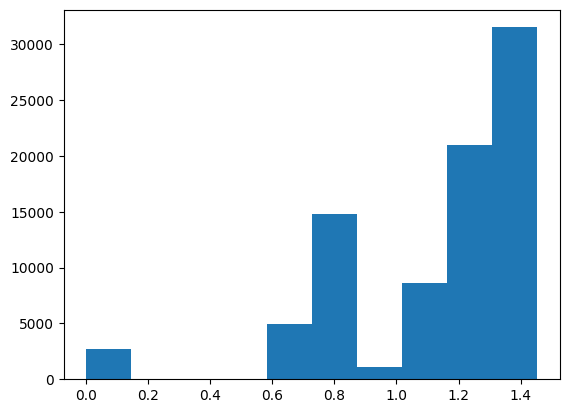

In [19]:
import matplotlib.pyplot as plt

plt.hist(edge_alpha+edge_beta)

In [20]:
from sphedron import MeshTransfer
from sphedron.mesh import UniformMesh
uni_mesh = UniformMesh(resolution=0.5)

In [21]:
transfer = MeshTransfer(sender_mesh=mesh, receiver_mesh=uni_mesh, n_neighbors=2)

In [28]:
vals = transfer.transfer(node_area)
vals = np.maximum(vals, vals[vals>0].min())

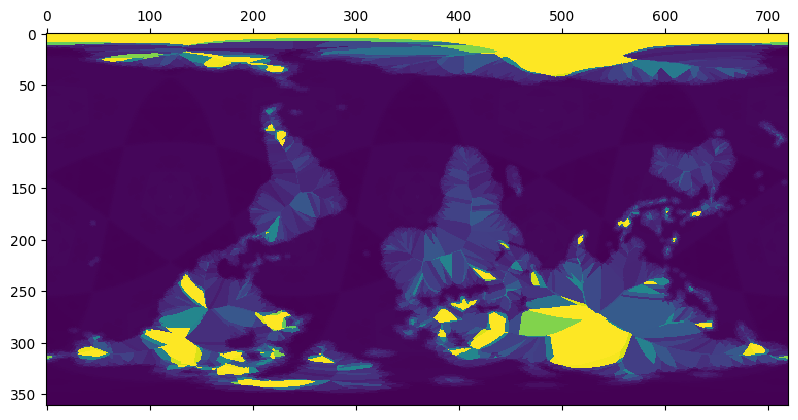

In [25]:
plt.matshow(uni_mesh.reshape(1/np.maximum(vals, vals[vals>0].min())))

In [26]:
import scipy.sparse as sp

In [29]:
# n_area = np.maximum(node_area, node_area[vals>0].min()
n_area = node_area.copy()
n_area[n_area==0]=1.0

In [31]:
C = sp.coo_matrix((edge_weight, (edges[:,0], edges[:,1])), shape=(nodes.shape[0], nodes.shape[0]))
A_1 = sp.coo_matrix((1/n_area**.5, (np.arange(nodes.shape[0]),np.arange(nodes.shape[0]))), 
                    shape=(nodes.shape[0], nodes.shape[0]))

In [32]:
C

<COOrdinate sparse matrix of dtype 'float64'
	with 84854 stored elements and shape (29176, 29176)>

In [33]:
C = C + C.T

In [34]:
# L = A_1.dot(sp.csgraph.laplacian(C))
# L = A_1.dot(sp.csgraph.laplacian(C)).dot(A_1)
L = sp.csgraph.laplacian(C)

In [35]:
L

<COOrdinate sparse matrix of dtype 'float64'
	with 193420 stored elements and shape (29176, 29176)>

In [36]:
np.random.seed(42)
cotheta = np.deg2rad(90-uni_mesh.nodes_latlong[:,0])
# cotheta = cotheta * (np.cos(np.random.uniform(0.9,1.0,cotheta.shape))/2.0+1)
psi = np.deg2rad(uni_mesh.nodes_latlong[:,1])
a = 7
b = 5
f = np.cos(a*cotheta)*np.cos(b*psi)

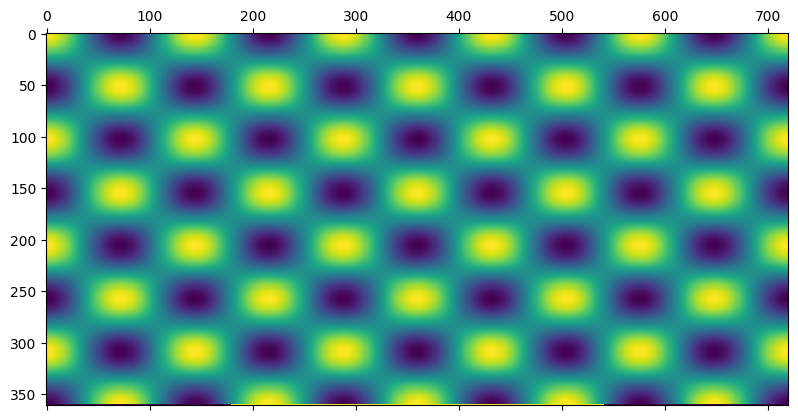

In [37]:
plt.matshow(uni_mesh.reshape(f))

In [38]:
cost = np.cos(cotheta)
sint = np.sin(cotheta)
cosat = np.cos(a*cotheta)
sinat = np.sin(a*cotheta)
cosbp = np.cos(b*psi)

delta_f = -a*cosbp*(cost*sinat+a*sint*cosat)/sint - cosat*cosbp*(b**2)/sint**2

/tmp/ipykernel_20660/336776701.py:7: RuntimeWarning: invalid value encountered in divide
  delta_f = -a*cosbp*(cost*sinat+a*sint*cosat)/sint - cosat*cosbp*(b**2)/sint**2
/tmp/ipykernel_20660/336776701.py:7: RuntimeWarning: divide by zero encountered in divide
  delta_f = -a*cosbp*(cost*sinat+a*sint*cosat)/sint - cosat*cosbp*(b**2)/sint**2


In [44]:
# np.where(np.isnan(delta_f))

In [45]:
# delta_f[np.isnan(delta_f)]=np.min(delta_f[~np.isnan(delta_f)])

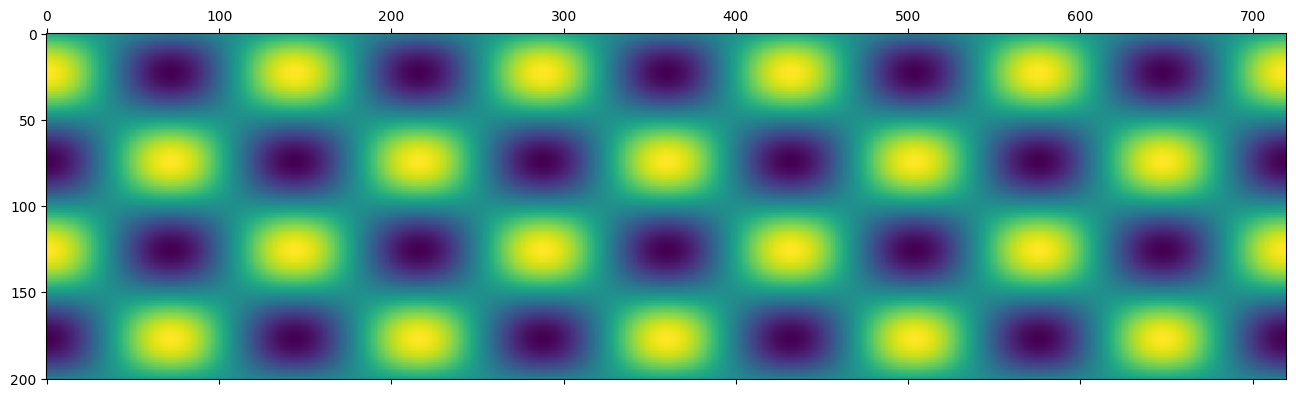

In [39]:
plt.matshow(uni_mesh.reshape(f)[80:][:-80])

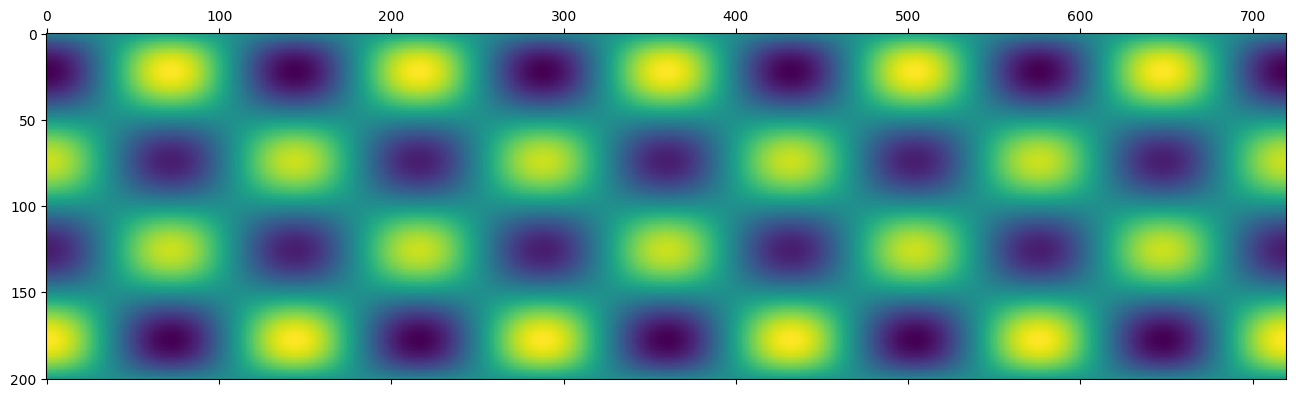

In [40]:
# plt.matshow(uni_mesh.reshape(delta_f)[50:][:-50])
plt.matshow(uni_mesh.reshape(delta_f)[80:][:-80])

In [51]:
g_transfer = MeshTransfer(sender_mesh=uni_mesh, receiver_mesh=mesh,n_neighbors=5)

In [52]:
mesh_f = g_transfer.transfer(f) 
mesh_delta_f = L.dot(mesh_f)

In [53]:
reconstruct_f = -transfer.transfer(mesh_delta_f)

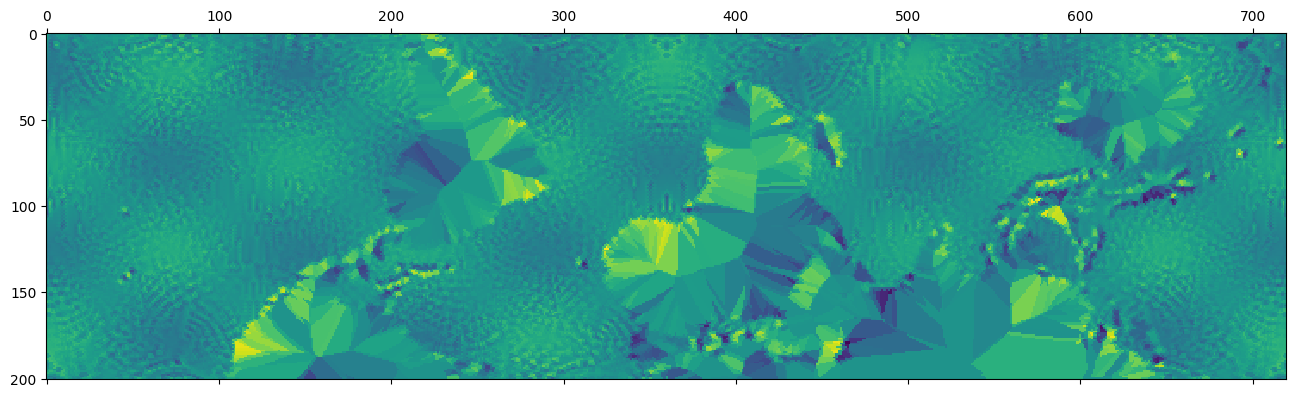

In [54]:
plt.matshow(uni_mesh.reshape(reconstruct_f)[80:][:-80])

In [55]:
uni_mesh.reshape(delta_f).shape

(361, 720)

In [56]:
uni_mesh.uniform_coords

array([[ -90. , -180. ],
       [ -89.5, -180. ],
       [ -89. , -180. ],
       ...,
       [  89. ,  179.5],
       [  89.5,  179.5],
       [  90. ,  179.5]], shape=(259920, 2))

In [57]:
L_coo = L.tocoo()

In [58]:
import cupyx.scipy.sparse as cusp
import cupyx.scipy.sparse.linalg

In [59]:
cu_L = cusp.coo_matrix(L_coo)

In [92]:
%%time
e,v = sp.linalg.eigsh(L, k=1024, which='SM')

CPU times: user 2h 20min 34s, sys: 2.57 s, total: 2h 20min 37s
Wall time: 9min 38s


In [ ]:
%%time
cu_e,cu_v = cusp.linalg.eigsh(cu_L, k=128, which="SA")

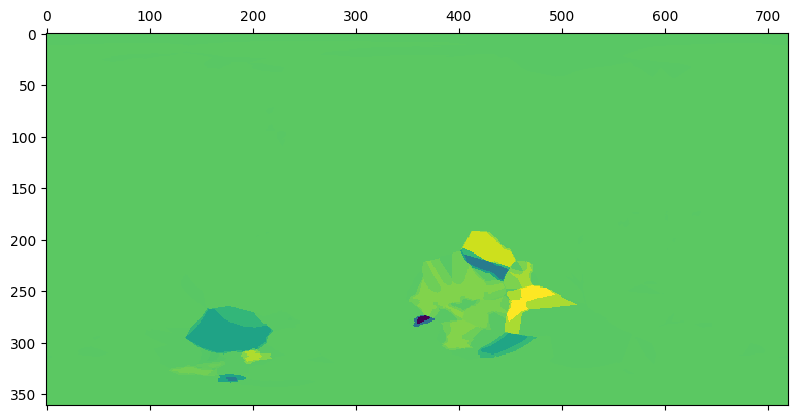

In [93]:
plt.matshow(uni_mesh.reshape(transfer.transfer(v[:,2])))

In [94]:
cu_v

NameError: name 'cu_v' is not defined

In [95]:
v

array([[-7.65620522e-05, -1.25045651e-03,  1.75789126e-03, ...,
        -5.55748940e-03, -2.28043374e-03,  1.05066780e-04],
       [-7.65620522e-05, -1.25045651e-03,  1.75789126e-03, ...,
        -1.86621652e-03,  5.66904336e-03,  6.55068572e-03],
       [-7.65620522e-05, -1.25045651e-03,  1.75789126e-03, ...,
         3.00814294e-03,  3.58372720e-03, -1.05410402e-02],
       ...,
       [-7.65620522e-05, -1.25045651e-03,  1.75789126e-03, ...,
        -6.53919180e-03,  7.70435830e-03,  1.27116108e-02],
       [-7.65620522e-05, -1.25045651e-03,  1.75789126e-03, ...,
        -8.58197583e-03,  1.49057432e-02,  2.33380584e-02],
       [-7.65620522e-05, -1.25045651e-03,  1.75789126e-03, ...,
        -5.27411576e-03,  1.04282920e-02,  1.74796772e-02]],
      shape=(29176, 1024))

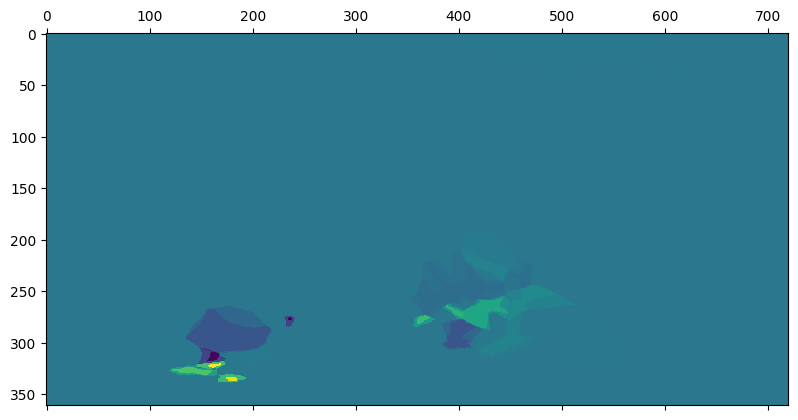

In [96]:
plt.matshow(uni_mesh.reshape(transfer.transfer(v[:,1])))

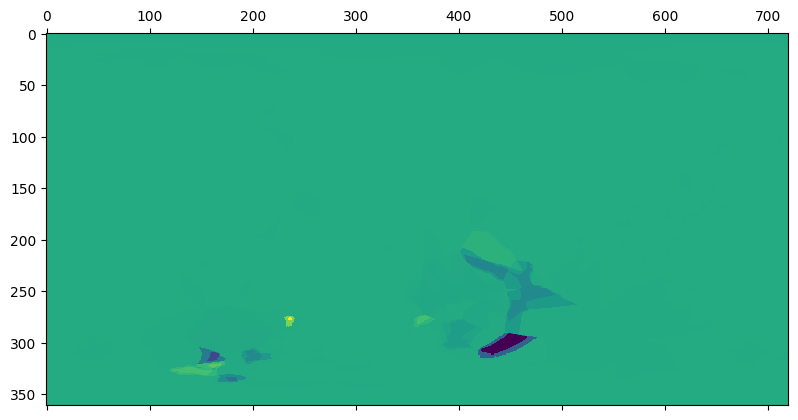

In [97]:
plt.matshow(uni_mesh.reshape(transfer.transfer(v[:,5])))

In [98]:
f_coef = v.T.dot(mesh_f)
reconst = v.dot(f_coef)

In [99]:
np.linalg.norm(mesh_f -v.dot(f_coef))

np.float64(12.084139012473885)

In [100]:
np.linalg.norm(mesh_f)

np.float64(85.03737920758944)

In [101]:
np.linalg.norm(mesh_f -v.dot(f_coef))/np.linalg.norm(mesh_f)

np.float64(0.14210385039001058)

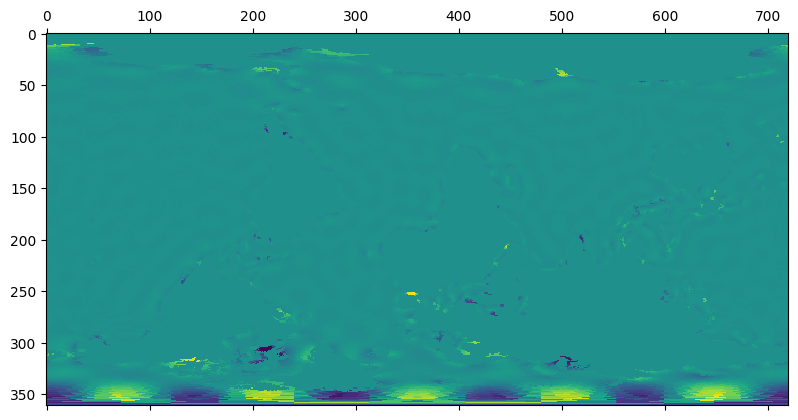

In [102]:
diff = transfer.transfer(mesh_f-reconst)
diff[get_mesh_landmask(uni_mesh)]=0.0
plt.matshow(uni_mesh.reshape(diff))

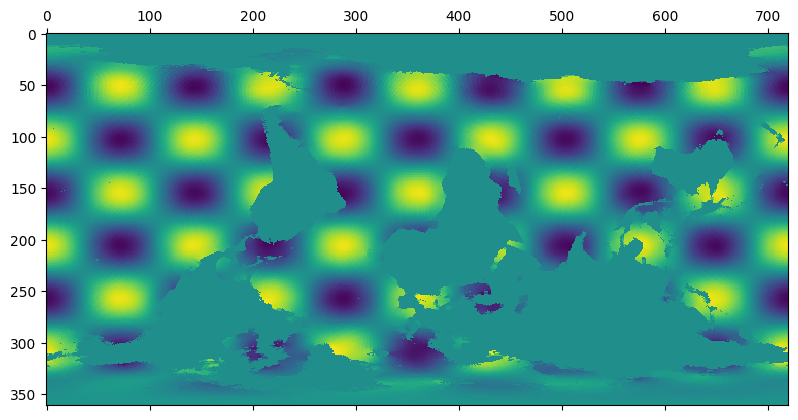

In [103]:
rec = transfer.transfer(reconst)
rec[get_mesh_landmask(uni_mesh)]=0.0
plt.matshow(uni_mesh.reshape(rec))

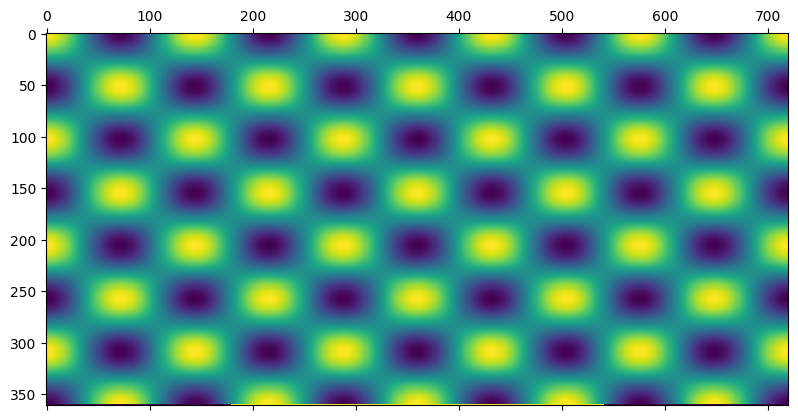

In [104]:
plt.matshow(uni_mesh.reshape(f))

In [83]:
uni_m = UniformMesh()
uni_m.mask_nodes(get_mesh_landmask(uni_m))

In [ ]:
tr = MeshTransfer(uni